In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re
from scipy import stats
import shap
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D  
from datetime import timedelta

Make sure to read in raw data, before pre-processing. Code requires only numerical data frames with no NaN values. Code also assumes features have the same names as found in the appendix of the "ICER_Final_Report.docx" appendix for SLURM data, Due to pre-processing package "datetime", data must be read in via pandas


Example of loading data.

df = pd.read_csv("DID_FINAL_SLURM_OCT_2023_aggregated.csv")

Inital Pre-processing of the SLURM dataframe

In [3]:
#Pre-Processing with Shams Code
slurm=df
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])
slurm['End'] = pd.to_datetime(slurm['Start'])

In [4]:
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if isinstance(mem_str, (int, float, complex)):   # if its a numeric type zero
        return float(mem_str)
    elif mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    else:
        return float(mem_str)    # when its a string zero '0'

In [5]:
# First drop rows with NA requested memory
slurm= slurm.dropna(subset=['ReqMem'])
slurm= slurm.dropna(subset=['MaxRSS'])


slurm['ReqMem_MB'] = slurm['ReqMem'].apply(convert_memory)
slurm['MaxRSS_MB'] = slurm['MaxRSS'].apply(convert_memory)

In [6]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm['Timelimit_'] = slurm['Timelimit'].apply(parse_time_string)
slurm['total_minutes'] = slurm['Elapsed'].apply(parse_time_string)

slurm['total_minutes'] = pd.to_timedelta(slurm['total_minutes']).dt.total_seconds() / 60  
slurm['Timelimit_'] = pd.to_timedelta(slurm['Timelimit_']).dt.total_seconds() / 60  

df=slurm


In [7]:
df.head()

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,Timelimit_,total_minutes
201,201,87461884,user_600,group_090,2023-09-08 18:34:09,2023-09-29 21:30:06,2023-09-29 21:30:06,1-08:12:31,COMPLETED,account_011,...,4500K,4,4,"lac-[084-086,193]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.500,2160.0,1932.516667
202,202,87461892,user_600,group_090,2023-09-08 18:34:11,2023-09-30 00:16:32,2023-09-30 00:16:32,1-06:03:08,COMPLETED,account_011,...,4540K,4,4,"lac-[142,192,345,349]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540,2160.0,1803.133333
203,203,87461900,user_600,group_090,2023-09-08 18:34:13,2023-09-30 01:07:56,2023-09-30 01:07:56,1-05:26:01,COMPLETED,account_011,...,4536K,4,4,"lac-[080-081,342-343]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.536,2160.0,1766.016667
204,204,87461908,user_600,group_090,2023-09-08 18:34:15,2023-09-30 03:06:56,2023-09-30 03:06:56,1-06:09:06,COMPLETED,account_011,...,4540K,4,4,"lac-[031,136,346-347]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540,2160.0,1809.100000
205,205,87461916,user_600,group_090,2023-09-08 18:34:18,2023-09-30 08:13:45,2023-09-30 08:13:45,1-06:16:43,COMPLETED,account_011,...,4604K,4,4,"lac-[083,196,344,348]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.604,2160.0,1816.716667


In [8]:
#Feature Set to be used in Numerical Clustering models (Anything using PCA)
features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_','ReqMem_MB']

This is where the dimesion reduced data frames are created, using only numeric features from the SLURM data frame. Features are scaled using a log-transformation

In [9]:
pca5=PCA(5)

df_pca5=df[features3]
df_pca5=np.log10(df_pca5)
df_pca5 = pca5.fit_transform(df_pca5)

pca3=PCA(3)

df_pca3=df[features3]
df_pca3=np.log10(df_pca3)
df_pca3 = pca3.fit_transform(df_pca3)


df_pca3 = pd.DataFrame(df_pca3, columns=['1st feature', 
                                          '2nd feature',
                                          '3rd feature'])
df_pca3

,1st feature,2nd feature,3rd feature
0,4.496051,0.778034,1.505580
1,4.457472,0.793370,1.496210
2,4.445893,0.797972,1.493398
3,4.459311,0.792638,1.496657
4,4.461650,0.791709,1.497225
...,...,...,...
1449977,-0.339319,2.302176,-0.450351
1449978,0.566273,0.290256,0.546012
1449979,2.818491,0.375392,0.140060
1449980,2.807200,0.379880,0.137318


This is also shown in the K-Means clustering notebook. Here, we are getting a break down of the explained variance ratio of each of the principal components, initially by reducing the dimesions of the dataframe from 8 -> 5. When visualizing the output of clusters in other notebooks, dimensions are reduced from 8 -> 3 and 2. We also output the effect each of the orginal 8 features had in the new principal components created, as well as there normalized value.

In [10]:
print("Explained Variance for Each Principal Component (PC=5):")
for i, var in enumerate(pca5.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca5.components_.T, columns=[f'PC{i+1}' for i in range(pca5.n_components_)], index=df[features3].columns)


print("Loadings for PC5:")
print(loadings_df[['PC1', 'PC2','PC3','PC4','PC5']])


for column in loadings_df.columns:
    loadings_df[column] = loadings_df[column].abs()  
    sum_abs = loadings_df[column].sum()  
    loadings_df[column] /= sum_abs  
print("-------------------------------------------")
print("Normalized Values:")
print(loadings_df)

Explained Variance for Each Principal Component (PC=5):
PC1: 67.17%
PC2: 13.03%
PC3: 12.63%
PC4: 6.97%
PC5: 0.16%
Loadings for PC5:
                    PC1       PC2       PC3       PC4       PC5
CPUTimeRAW     0.691185 -0.046488  0.297456  0.178018 -0.012239
ReqCPUS        0.100829  0.416695  0.280669  0.369029 -0.023216
AllocCPUS      0.100500  0.416593  0.283571  0.368939 -0.017348
ReqNodes       0.003097  0.009174  0.013853  0.003901  0.557246
NNodes         0.006017  0.017755  0.024448  0.006583  0.829562
total_minutes  0.590685 -0.463080  0.013884 -0.190921  0.005109
Timelimit_     0.389598  0.533560 -0.736595 -0.144492  0.008544
ReqMem_MB      0.035431  0.388748  0.456922 -0.799139 -0.014668
-------------------------------------------
Normalized Values:
                    PC1       PC2       PC3       PC4       PC5
CPUTimeRAW     0.360491  0.020282  0.141148  0.086374  0.008338
ReqCPUS        0.052588  0.181797  0.133183  0.179052  0.015816
AllocCPUS      0.052416  0.181752  0.

Here, we use the clustering metric "inertia" to pick an ideal cluster amount for the K-Means algorithm to try to cluster the data with. Inertia is calculated by getting the distance between each data point and its centroid (the center of the cluster), squaring this distance, and summing these squares across one cluster. A cluster value (k) with low inertia should be used. Here, 3 was when the graph starts to flatten, so k=3 was used for subequent clustering with K-Means

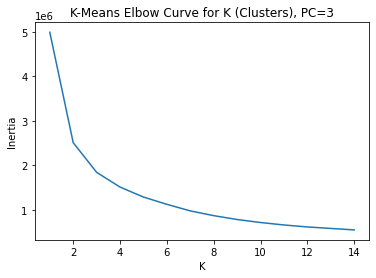

In [11]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_pca3)
    distortions.append(kmeanModel.inertia_)
    
plt.plot(K,distortions)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Curve for K (Clusters), PC=3')
plt.savefig('KMeans_ELBOW.png', dpi=200)